<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Research-Question" data-toc-modified-id="Research-Question-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Research Question</a></span></li><li><span><a href="#Import-Packages" data-toc-modified-id="Import-Packages-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Import Packages</a></span></li><li><span><a href="#Build-the-network" data-toc-modified-id="Build-the-network-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Build the network</a></span></li><li><span><a href="#Structural-Features" data-toc-modified-id="Structural-Features-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Structural Features</a></span></li><li><span><a href="#Rebalancing" data-toc-modified-id="Rebalancing-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Rebalancing</a></span></li><li><span><a href="#Louvain-commmunity-detection" data-toc-modified-id="Louvain-commmunity-detection-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Louvain commmunity detection</a></span></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Conclusion</a></span></li><li><span><a href="#References:" data-toc-modified-id="References:-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>References:</a></span></li></ul></div>

# Bike Network Analysis

This project work is located on the GitHub repository and can be found at: https://github.com/andygubser/bike_network_analysis

## Research Question

In [17]:
from IPython.display import Image, IFrame
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:90% !important; }</style>"))
IFrame(src="https://live.staticflickr.com/video/28896995634/23c469a606/360p.mp4?s=eyJpIjoyODg5Njk5NTYzNCwiZSI6MTU5MjQ4MTI0MCwicyI6IjI0MGFlNDQ1ZjljODk0MWU4NDRjZTQ2ZmYxZDhiNTk0Y2NjOTcxMmYiLCJ2IjoxfQ",
       width="560", height="315")

- We show how to re-balance bike supply at each station by redirecting trips to the next station with bike shortage with a e.g. mobility-pricing service
    - Where do such re-balancing issues exist? $\rightarrow$ in-degree vs. out-degree
    - Re-Balancing should happen within a community. Trips are redirected to close stations with bike shortages. $\rightarrow$ community detection

## Import Packages

In [2]:
import os, sys
os.chdir("..")
sys.path.append(os.getcwd())

In [3]:
# import prepared data
from preprocessor.network_builder import NetworkBuilder
from preprocessor.map_builder import MapBuilder

# import external packages
import networkx as nx
import community as community_louvain
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.cm as cm
import contextily as ctx
import seaborn as sns

sns.set("poster")
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [4]:
network_builder = NetworkBuilder()
nodes, edges = network_builder.nodes, network_builder.edges
xmin, xmax, ymin, ymax = network_builder.min_max_nodes

geodata_nyc = MapBuilder().data

## Build the network

In [5]:
margin = 1000
xmin = min([tpl[0] for tpl in nodes.values()])-margin
ymin = min([tpl[1] for tpl in nodes.values()])-margin
xmax = max([tpl[0] for tpl in nodes.values()])+margin
ymax = max([tpl[1] for tpl in nodes.values()])+margin

- **Graph:** This class implements an undirected graph. It ignores multiple edges between two nodes. It does allow self-loop edges between a node and itself.
- **DiGraph:** Directed graphs, that is, graphs with directed edges. Operations common to directed graphs, (a subclass of Graph).
- **MultiGraph:** A flexible graph class that allows multiple undirected edges between pairs of nodes. The additional flexibility leads to some degradation in performance, though usually not significant.
- **MultiDiGraph:** A directed version of a MultiGraph. 

In [6]:
# multi directed graph with nodes and edges 
G1 = nx.MultiDiGraph(name="multi_directed_graph")
G1.add_nodes_from(nodes)
G1.add_edges_from(edges)

# simple directed graph with nodes and edges
G2 = nx.DiGraph(name="directed_graph")
G2.add_nodes_from(nodes)
G2.add_edges_from(edges)

# gaph with nodes only
G3 = nx.Graph(name="nodes_only")
G3.add_nodes_from(nodes)

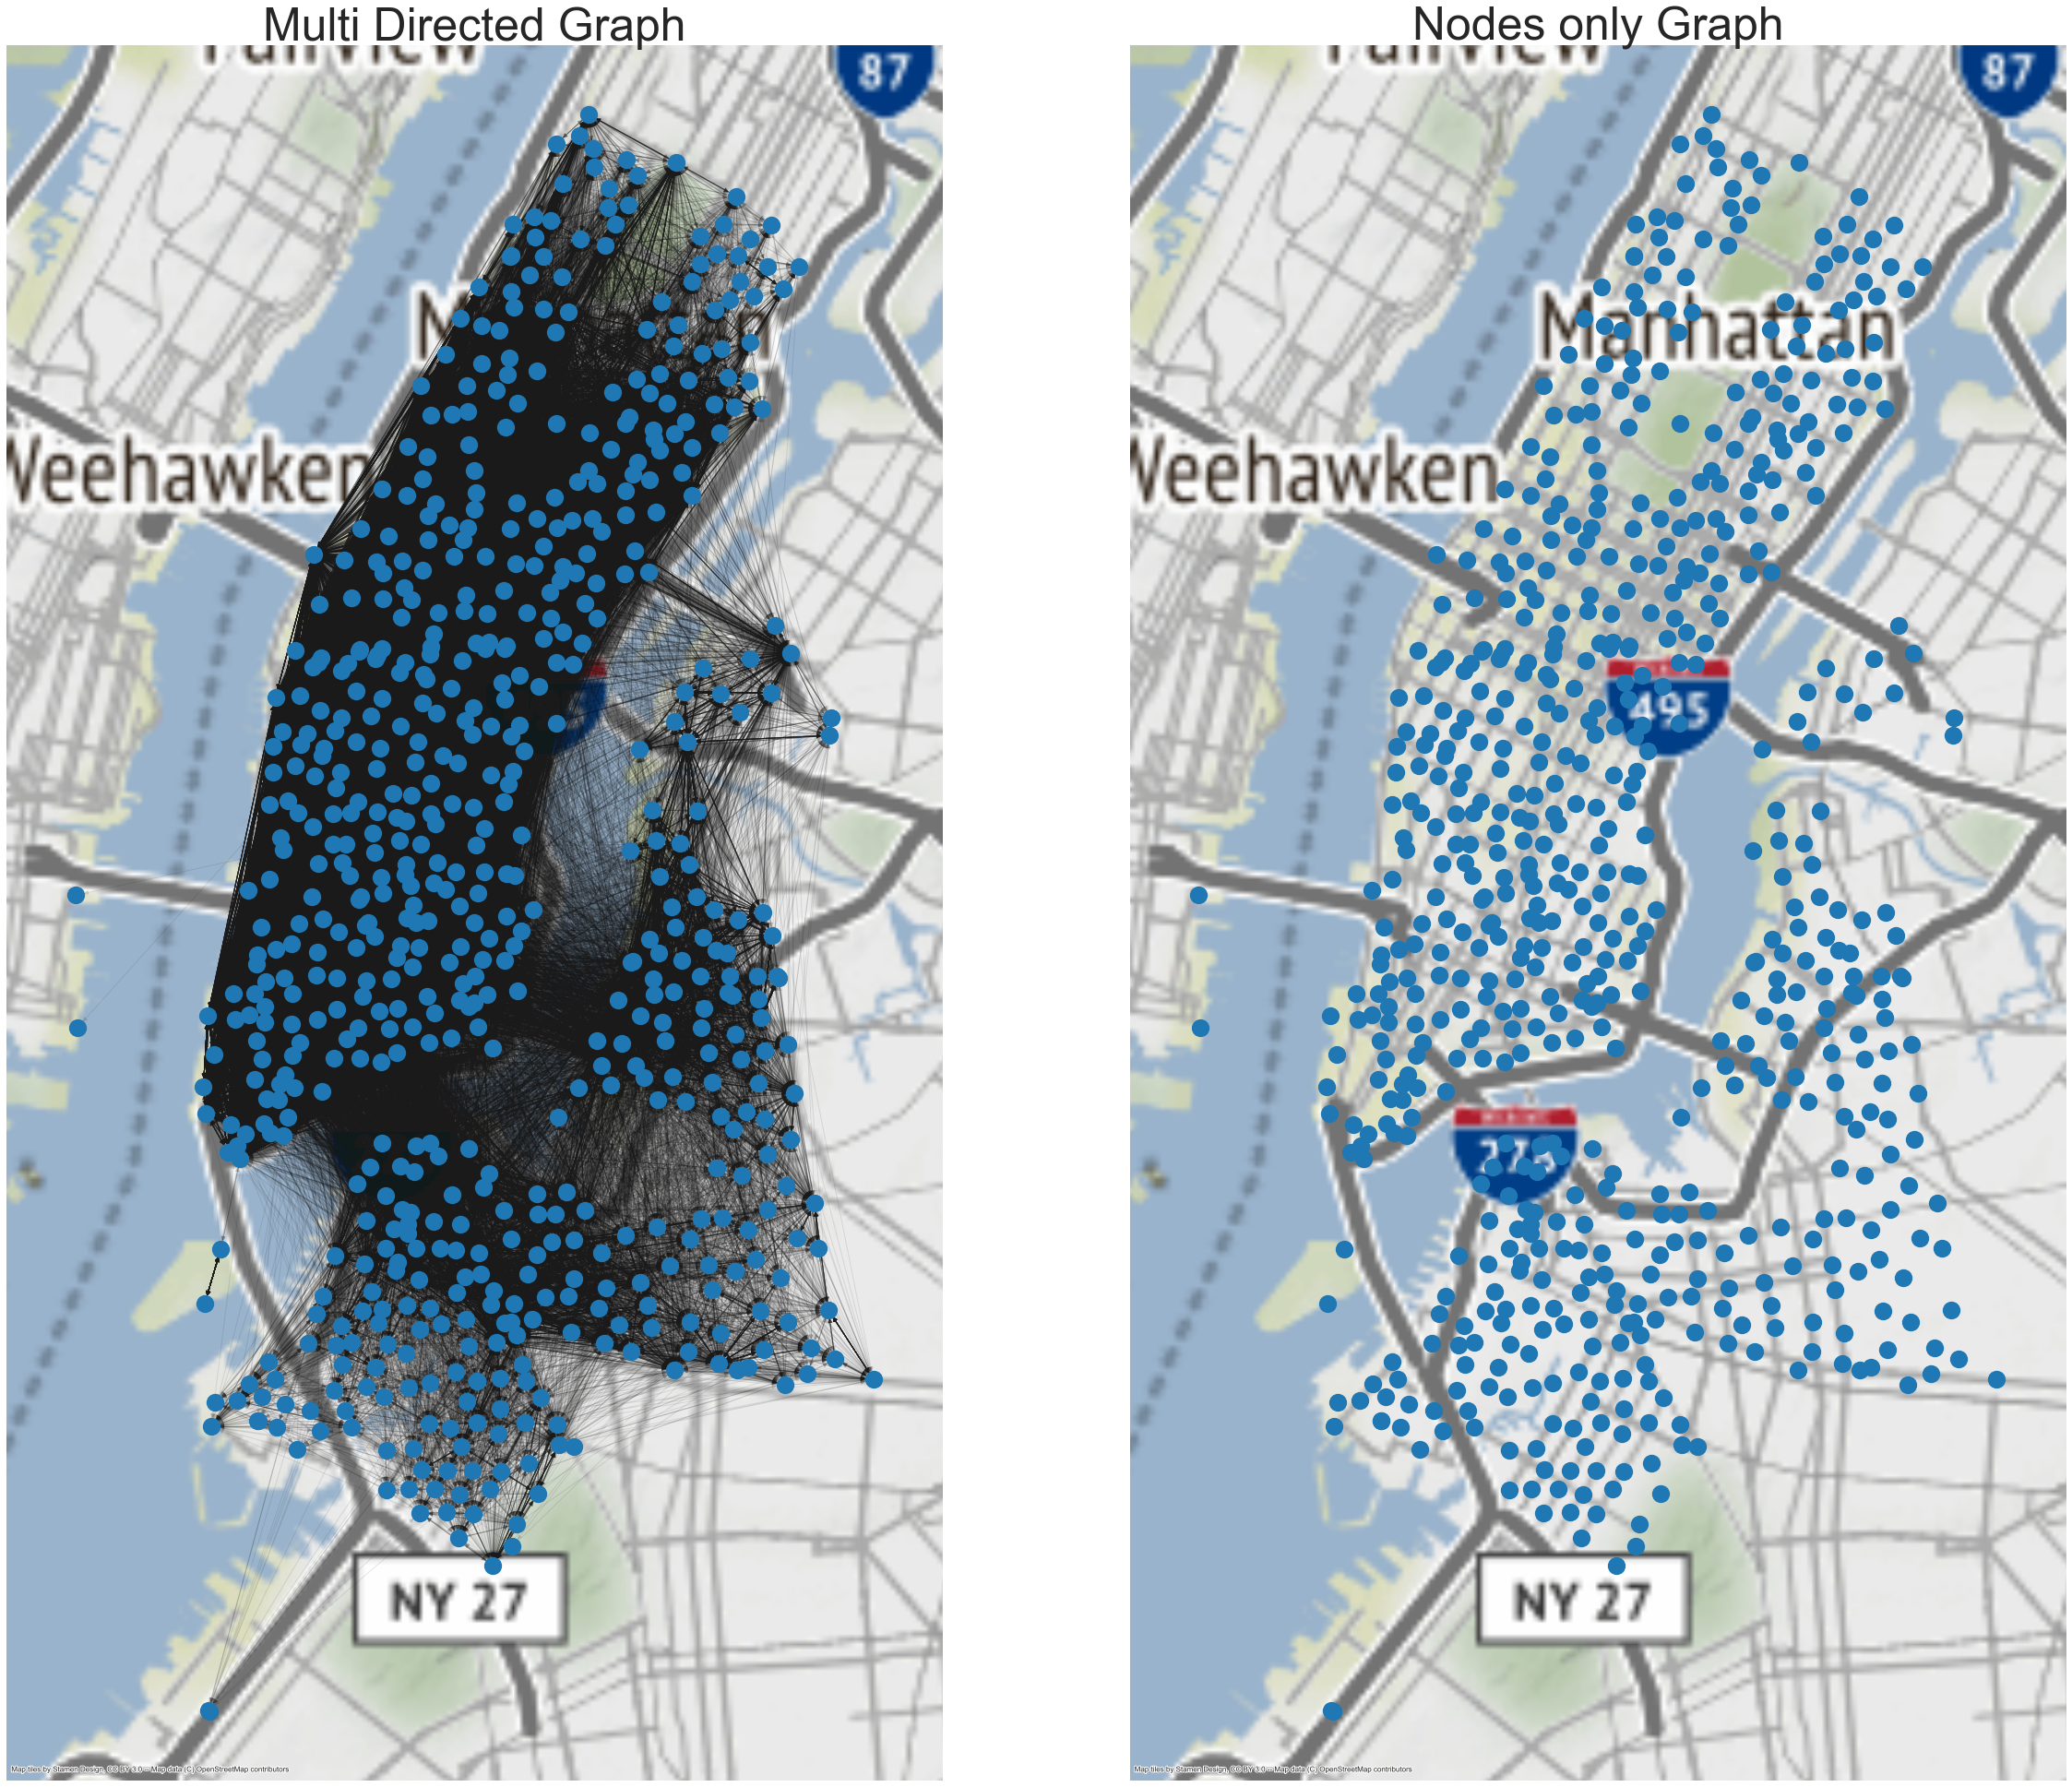

In [7]:
# plot the network
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(40,40), sharey=True)

# multi directed graph
axes[0].set_title("Multi Directed Graph", 
                  fontsize=50)
nx.draw_networkx_nodes(G1,
                       pos=nodes,
                       ax=axes[0])
nx.draw_networkx_edges(G1,
                       alpha=0.1,
                       pos=nodes,
                       ax=axes[0])

basemap = geodata_nyc.plot(alpha=0, 
                           ax=axes[0])
ctx.add_basemap(basemap)

# nodes only graph
axes[1].set_title("Nodes only Graph", 
                  fontsize=50)
nx.draw_networkx_nodes(G3,
                       pos=nodes,
                       ax=axes[1])
basemap = geodata_nyc.plot(alpha=0, 
                           ax=axes[1])
ctx.add_basemap(basemap)

for ax in axes[0], axes[1]:
    ax.set_xlim((xmin, xmax))
    ax.set_ylim((ymin, ymax))
#    ax.axes.get_xaxis().set_visible(False)
#    ax.axes.get_yaxis().set_visible(False)
    ax.axis('off')
plt.show()

## Structural Features
- Identify the properties of the bike sharing network
- Identify stations and their usage frequencies and behavior (from station X to station Y)

- Basic Terms
    - Density: How many of the possible ties are present in the network?
    - Reciprocity: How many of the dyads are mutual? (only makes sense in directed networks)
    - Clustering: How many of the triads are "closed"? (i.e. don't have null dyads → triangles)
    - Centrality: Centrality,	i.e.	how	much each actor is "in the center" of a network	is one of the key concepts in network analysis
        * Degree Centrality: How many edges does a node have?
        * Closeness: How short are the distances to all other nodes? 
        * Betweenness: How many shortest paths go through a certain node?
        * Eigenvector (Bonacich) Centrality: A node has central neighbours

In [8]:
print(f"{nx.info(G1)} ")
print(f"Density: {round(nx.density(G1), 2)}")
print(f"Reciprocity: {round(nx.reciprocity(G1), 2)}")
print(f"Number of Selfloops: {nx.number_of_selfloops(G1)}")
# list(nx.nodes_with_selfloops(G1))

Name: multi_directed_graph
Type: MultiDiGraph
Number of nodes: 646
Number of edges: 276795
Average in degree: 428.4752
Average out degree: 428.4752 
Density: 0.66
Reciprocity: 0.61
Number of Selfloops: 5321


- in degree -> end station (return)
- out degree -> start station (pick-up)
- Average in degree = average out degree $\rightarrow$ all bikes picked-up are returned

In [9]:
def to_dataframe(centrality_measure):
    return pd.DataFrame.from_dict(data=centrality_measure, orient="index")

centrality_degree = to_dataframe(nx.degree_centrality(G1))
centrality_indegree = to_dataframe(nx.in_degree_centrality(G1))
centrality_outdegree = to_dataframe(nx.out_degree_centrality(G1))
centrality_betweenness = to_dataframe(nx.betweenness_centrality(G2))
centrality_eigenvector = to_dataframe(nx.eigenvector_centrality(G2))

df_centrality = pd.concat([centrality_indegree, 
                           centrality_outdegree, 
                           centrality_betweenness, 
                           centrality_eigenvector], 
                          axis=1)
df_centrality.columns = ["centrality_indegree", 
                         "centrality_outdegree", 
                         "centrality_betweenness", 
                         "centrality_eigenvector"]
df_centrality["diff_indegree_outdegree"] = df_centrality["centrality_indegree"] - df_centrality["centrality_outdegree"]
df_centrality.head()

centrality_indegree  centrality_outdegree  centrality_betweenness  \
72              1.001550              1.074419                0.000972   
79              0.829457              0.835659                0.001654   
82              0.339535              0.361240                0.000196   
83              0.457364              0.474419                0.006902   
116             1.660465              1.711628                0.001448   

     centrality_eigenvector  diff_indegree_outdegree  
72                 0.056920                -0.072868  
79                 0.057643                -0.006202  
82                 0.026670                -0.021705  
83                 0.015269                -0.017054  
116                0.066303                -0.051163

## Rebalancing
- where do an oversupply or shortage of bike exist?
- what may be the cause (office buildings, hubs, residentail areas, subway stations)?

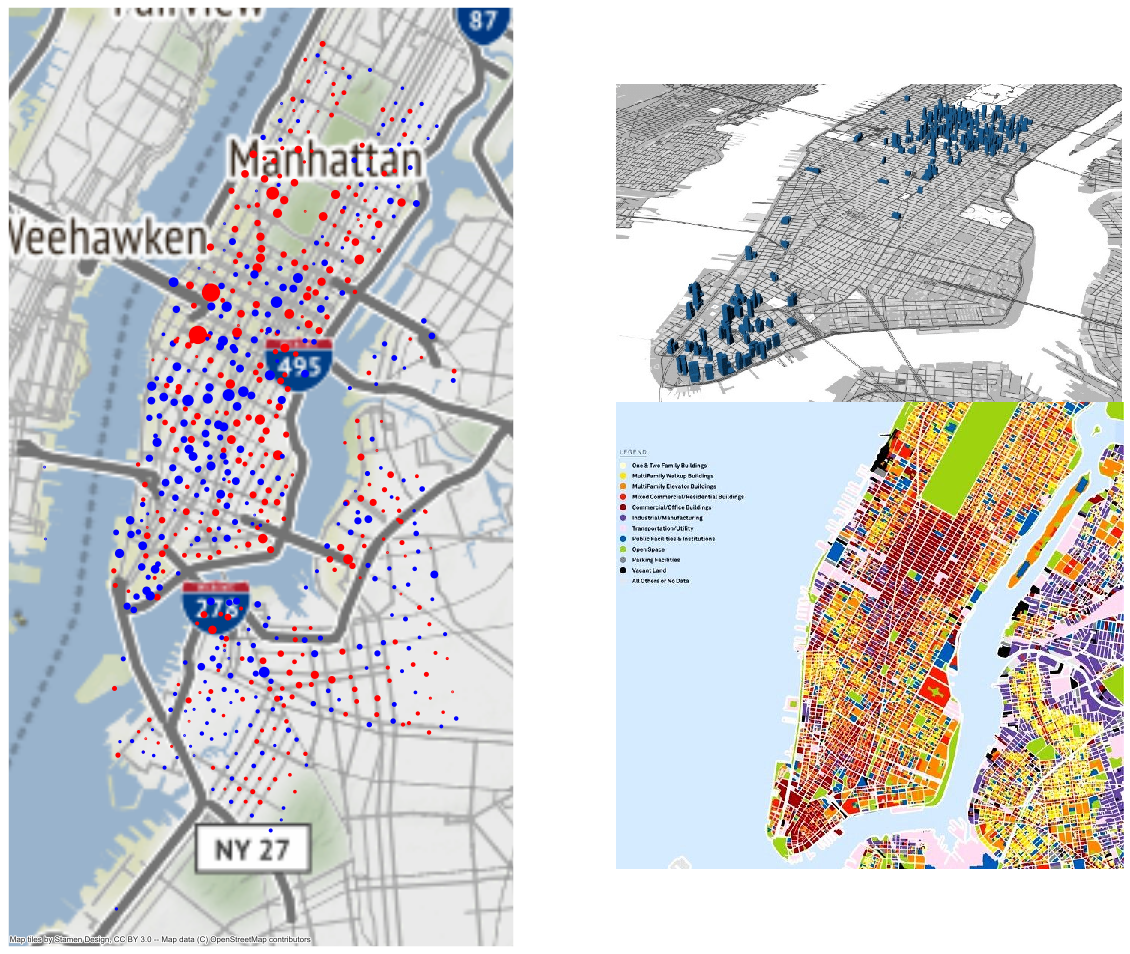

In [10]:
# positive difference means more bike returned and vice versa
degree_diff = {}
# blue for more bike, red for less bike
pos_neg_color = {}
for node in nodes:
    degree_diff[node] = G1.in_degree(node) - G1.out_degree(node)
    pos_neg_color[node] = 'blue' if degree_diff[node] > 0 else 'red'

# scale the max different to the max size to 100 
max_diff = max(degree_diff.values())
max_size = 100

for key in degree_diff.keys():
    degree_diff[key] = (degree_diff[key] * max_size) / max_diff
    
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,20))

# rebalancing map
basemap = geodata_nyc.plot(alpha=0, edgecolor="k", ax=axes[0])
ctx.add_basemap(basemap)
nx.draw_networkx_nodes(G1, ax=axes[0], pos=nodes, node_size=np.absolute(list(degree_diff.values())), 
                       node_color= list(pos_neg_color.values()))

img=mpimg.imread('images/newyork_plan.png')
axes[1].imshow(img)
axes[1].axis('off')

axes[0].set_xlim((xmin, xmax))
axes[0].set_ylim((ymin, ymax))
axes[0].axes.get_xaxis().set_visible(False)
axes[0].axes.get_yaxis().set_visible(False)

plt.show()

# blue: surplus in bike supply
# red: shortage in bike supply

## Louvain commmunity detection
- The Louvain community detection algorithm: The Louvain algorithm is a hierarchical clustering algorithm, that recursively merges communities into a single node and executes the modularity clustering on the condensed graphs.
- The three green "outliers" (387, 412, 3250) based on Manhattan are strongly connected to the west of NYC. Further analysis shows that these three stations are on a main bike route that connects east and west. 
- Red dots are distributed more in residential areas, blue  dots are more in commercial and office building areas (working areas). People might use the bike to go to work, but use another transportation to commute home. May be we should reduce the rental tarrifs in the evening at time people leave work for home.
- Community is considered as a cluster in the network. Nodes within a cluster has more relationships and connection within the community.

In [11]:
# Find community structure that has the maximal modularity
uG1 = G1.to_undirected()
partition = community_louvain.best_partition(uG1, random_state=80)
modularity = community_louvain.modularity(partition, uG1)
modularity

# list of partition values
partition_values = list(partition.values())
n_unique_partition_values = len(set(partition_values))

# list of corresponding colors
color_palette = sns.color_palette(palette="deep", n_colors=n_unique_partition_values)
array_color_palette = np.array(color_palette)
#sns.palplot(color_palette)

# replace partion values with color values
node_color = [color_palette[i] for i in partition_values]

node_list = [nodeid for nodeid in partition if partition[nodeid] == 0]
#df_partition = pd.DataFrame.from_dict(partition, orient="index")
labels = {387:387, 412:412, 3182:3182, 3245:3245, 3250:3250, 3254:3254, 3371:3371}

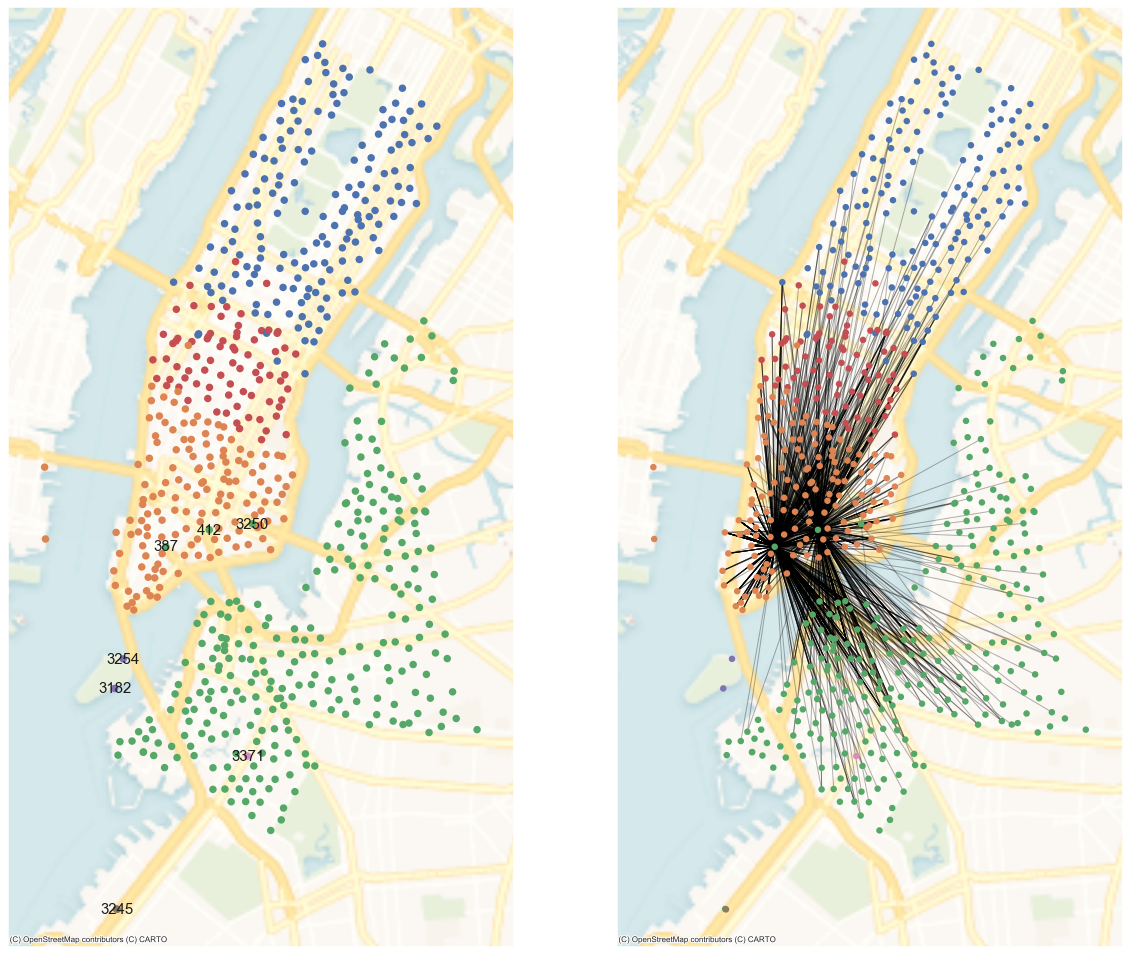

In [12]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,20))

# add open street map of NYC as basemap to Networkx graph
basemap = geodata_nyc.plot(alpha=0, edgecolor="k", ax=axes[0])
ctx.add_basemap(basemap, source=ctx.providers.CartoDB.VoyagerNoLabels)

# add Networkx graph
nx.draw_networkx_nodes(uG1, ax=axes[0], pos=nodes, node_size=30, node_color=node_color, with_labels = True)
nx.draw_networkx_labels(uG1, ax=axes[0], pos=nodes, font_size=15, labels=labels)

# look at the edges from and to these outlier stations
basemap = geodata_nyc.plot(alpha=0, edgecolor="k", ax=axes[1])
ctx.add_basemap(basemap, source=ctx.providers.CartoDB.VoyagerNoLabels)

# add Networkx graph
#nx.draw_networkx(uG1, ax=ax, pos=nodes, node_size=10, node_color=list(partition.values()))
nx.draw_networkx_nodes(uG1, ax=axes[1], pos=nodes, node_size=20, node_color=node_color, with_labels = True)
nx.draw_networkx_edges(uG1, ax=axes[1], pos=nodes, edge_color = 'black', alpha=0.3, edgelist=uG1.edges([387, 412, 3250]))

for ax in axes[0], axes[1]:
    ax.set_xlim((xmin, xmax))
    ax.set_ylim((ymin, ymax))
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

plt.show()

(-0.5, 589.5, 617.5, -0.5)

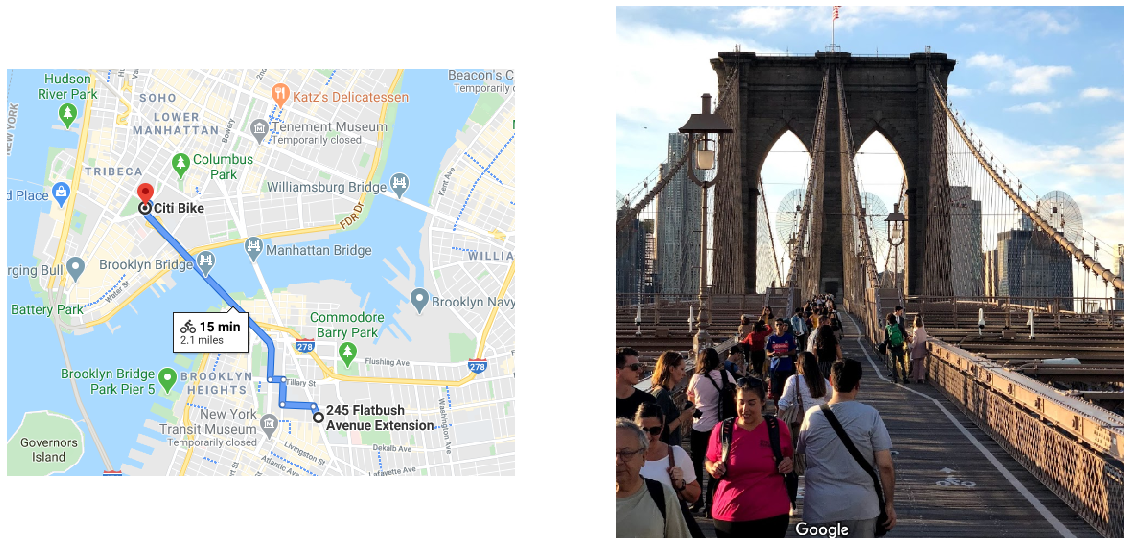

In [13]:
# read images
img_A = mpimg.imread('images/station387-map.PNG')
img_B = mpimg.imread('images/station387-brooklyn-bridge.PNG')

# display images
fig, ax = plt.subplots(1,2, figsize=(20,20))
ax[0].imshow(img_A);
ax[0].axis('off')
ax[1].imshow(img_B);
ax[1].axis('off')

(-0.5, 499.5, 374.5, -0.5)

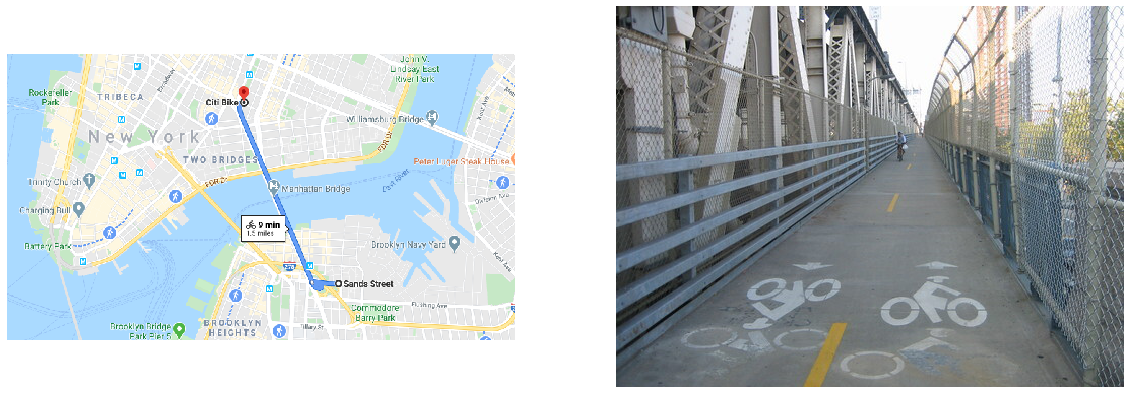

In [15]:
# read images
img_A = mpimg.imread('images/station412-map.PNG')
img_B = mpimg.imread('images/station412-mahattan-bridge.jfif')

# display images
fig, ax = plt.subplots(1,2, figsize=(20,20))
ax[0].imshow(img_A);
ax[1].imshow(img_B);
ax[0].axis('off')
ax[1].axis('off')

(-0.5, 719.5, 539.5, -0.5)

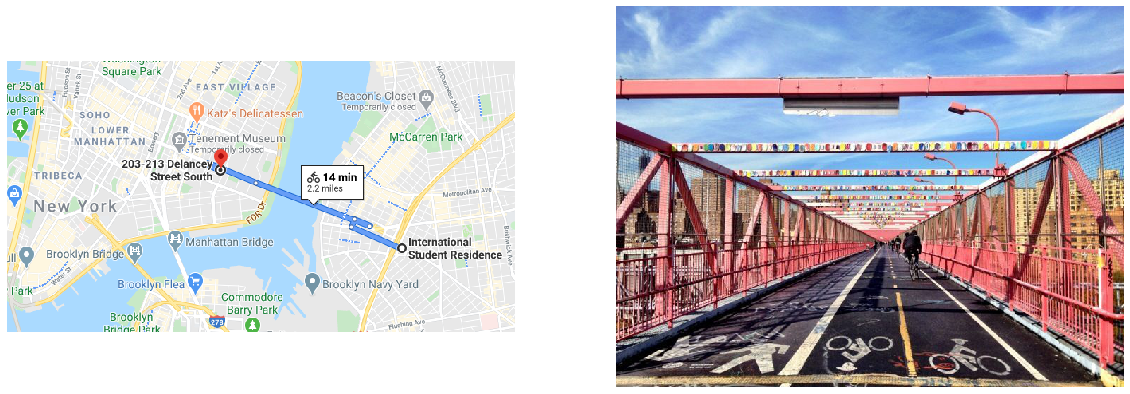

In [16]:
# read images
img_A = mpimg.imread('images/station3250-map.png')
img_B = mpimg.imread('images/station3250-brooklyn-bridge.jpg')

# display images
fig, ax = plt.subplots(1,2, figsize=(20,20))
ax[0].imshow(img_A);
ax[1].imshow(img_B);
ax[0].axis('off')
ax[1].axis('off')

## Conclusion
- Bikes can be redirected within the green community and the communities on Manhattan (blue, red, orange)
- Further research should consider working days vs. weekends, holidays, weather conditions
- Suggestions: based on the analysis we suggested dynamic pricing (or promotion) to match the user's riding needs and to balance bike supply.

## References:
* https://www.kaggle.com/mmmarchetti/game-of-thrones-network-analysis
* https://campus.datacamp.com/courses/introduction-to-network-analysis-in-python/introduction-to-networks?ex=4
* http://ethen8181.github.io/machine-learning/networkx/networkx.html
- https://live.staticflickr.com/video/28896995634/23c469a606/360p.mp4?s=eyJpIjoyODg5Njk5NTYzNCwiZSI6MTU5MjQ4MTI0MCwicyI6IjI0MGFlNDQ1ZjljODk0MWU4NDRjZTQ2ZmYxZDhiNTk0Y2NjOTcxMmYiLCJ2IjoxfQ
- https://www.researchgate.net/figure/NYC-New-York-City-office-buildings-larger-than-500-000-ft-46-452-m_fig1_337977453